## ANALYSIS

In [318]:
RESULT_JSON = "/Users/law/repos/viper/results/all_ops/full_all_ops.json"

In [319]:
import json

results_raw = json.loads(open(RESULT_JSON).read())
# assert results_raw["context"]["library_build_type"] != "debug"
BENCHMARKS =  results_raw["benchmarks"]
# print(BENCHMARKS)

In [320]:
from collections import defaultdict
runs = defaultdict(list)

ROCKS_DISK = ('DiskRocksDb', "RocksDB-SSD")
ROCKS = ('PmemRocksDb', "RocksDB")
PMEMKV = ('PmemKv', "PmemKV")
VIPER = ('Viper', 'Viper')
DRAM_MAP = ('DramMap', 'TBB Map')
HYBRID_FASTER = ('PmemHybridFaster', 'FASTER')
NVM_FASTER = ('NvmFaster', 'FASTER-NVM')

ALL_FIXTURES = [VIPER, ROCKS, PMEMKV, DRAM_MAP, HYBRID_FASTER, NVM_FASTER]
ALL_BM_TYPES = ['insert', 'get', 'update', 'delete']

def get_bm_type(bm_type_str):
    for t in ALL_BM_TYPES:
        if t in bm_type_str:
            return t
    raise RuntimeError(f"Unknown bm_type: {bm_type_str}")

for bm in BENCHMARKS:
    found = False
    for (fixture, _) in ALL_FIXTURES:
        bm_type = get_bm_type(bm['name'])
        if fixture in bm['name']:
            runs[(fixture, bm_type)].append(bm)
            found = True
            break
#     if not found: raise RuntimeError(f"Unknown fixture {bm['name']}")

for fixture, _ in ALL_FIXTURES:
    for bm_type in ALL_BM_TYPES:
        runs[(fixture, bm_type)].sort(key=lambda x: x['threads'])

# pprint.pprint(runs)

## PLOTS

In [321]:
from matplotlib import rcParams
import numpy as np
import matplotlib.pyplot as plt
rcParams.update(json.loads(open("matplot_conf.json").read()))

import pprint
# from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
#                                AutoMinorLocator)

MILLION = 1_000_000



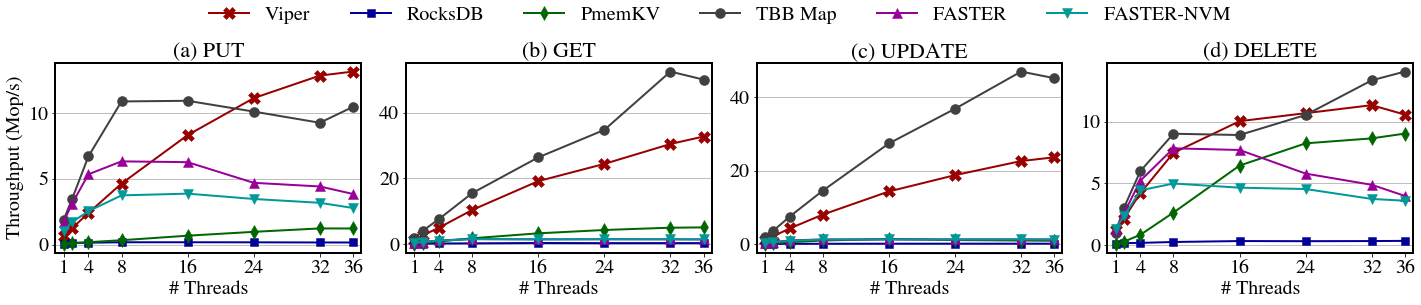

In [328]:
fig, (insert_ax, get_ax, update_ax, delete_ax) = plt.subplots(1, 4, figsize=(20, 4))

#           red        blue       green      grey       purple     turquoise
COLORS =  ['#990000', '#000099', '#006600', '#404040', '#990099', '#009999']
MARKERS = [('X', 12), ("s", 8),  ("d", 10), ("o", 10), ("^", 10), ('v', 10)]

def get_bm_ax(bm_type):
    if bm_type == 'insert': return insert_ax
    if bm_type == 'get': return get_ax
    if bm_type == 'update': return update_ax
    if bm_type == 'delete': return delete_ax
    raise RuntimeError(f"Unknown bm_type {bm_type}")

num_threads = sorted({run['threads'] for run in list(runs.values())[0]})

for bm_type, letter in zip(ALL_BM_TYPES, ['a', 'b', 'c', 'd']):
    ax = get_bm_ax(bm_type)
    ax.set_xlabel("# Threads", fontsize=20)
    ax.set_title(f"({letter}) {bm_type.upper()}", fontsize=22)
    colors = iter(COLORS)
    markers = iter(MARKERS)
    for (fixture, _) in ALL_FIXTURES:
        r = [run['items_per_second'] / MILLION for run in runs[(fixture, bm_type)]]
        marker, ms = next(markers)
        ax.plot(num_threads, r, marker=marker, ms=ms, color=next(colors), markeredgewidth=0.5, lw=2)
    x_ticks = np.append(ax.get_xticks(), 36)
    ax.set_xticks([1, 4, 8, 16, 24, 32, 36])
    ax.set_xlim(0, 37)
    ax.grid(axis='y', which='major')
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)


insert_ax.set_ylabel("Throughput (Mop/s)", fontsize=20)
insert_ax.set_title(f"(a) PUT", fontsize=22)

fig.legend(loc='upper center', labels=[f[1] for f in ALL_FIXTURES], 
           bbox_to_anchor=(0.5, 1.1), ncol=6, frameon=False, fontsize=20)

fig.savefig('charts/all_ops.pdf', bbox_inches='tight')
fig.savefig('charts/all_ops.svg', bbox_inches='tight')